# Facial Expression Detection using keras

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/facial-expression/fer2013/"))

# Any results you write to the current directory are saved as output.

['fer2013.csv']


# Fetching the Data from the specific Folder****

In [3]:
# get the data
filname = '../input/facial-expression/fer2013/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('../input/facial-expression/fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


# Appending the Data into a List. Convert the features into Array

In [4]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


In [5]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


# Reshaping the data into the required shape

In [6]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

# Splitting the data into training and testing

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

# Importing the libraries to build and train the network

In [16]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Building the Network.



In [9]:
model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))
    
    
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
   

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
__________

# Initilize parameters

In [13]:

num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

# Data Augmentation 

In [11]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
            

# Training the Model
Here we used checkpointer to save the weights having minimum val_loss of all.
lr_reduction is used to change the learning rate when the loss doesn't decrease for 5 epochs(patience=5)
early stopping is used when the loss doesn't change for 10 epochs(patience=10)

In [17]:
fw='best_model.h5'
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,patience=5,factor=.8)
history = model.fit_generator(data_generator.flow(X_train,y_train, batch_size),
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks=[checkpointer,es,lr_reduction],
                                validation_data=(X_test,y_test))

Epoch 1/50
 - 19s - loss: 0.9950 - acc: 0.6288 - val_loss: 0.9646 - val_acc: 0.6389

Epoch 00001: val_loss improved from inf to 0.96456, saving model to best_model.h5
Epoch 2/50
 - 17s - loss: 0.9781 - acc: 0.6333 - val_loss: 1.0435 - val_acc: 0.6088

Epoch 00002: val_loss did not improve from 0.96456
Epoch 3/50
 - 17s - loss: 0.9750 - acc: 0.6354 - val_loss: 0.9461 - val_acc: 0.6489

Epoch 00003: val_loss improved from 0.96456 to 0.94608, saving model to best_model.h5
Epoch 4/50
 - 18s - loss: 0.9634 - acc: 0.6443 - val_loss: 0.9421 - val_acc: 0.6473

Epoch 00004: val_loss improved from 0.94608 to 0.94208, saving model to best_model.h5
Epoch 5/50
 - 17s - loss: 0.9573 - acc: 0.6446 - val_loss: 0.9828 - val_acc: 0.6297

Epoch 00005: val_loss did not improve from 0.94208
Epoch 6/50
 - 17s - loss: 0.9449 - acc: 0.6515 - val_loss: 0.9454 - val_acc: 0.6461

Epoch 00006: val_loss did not improve from 0.94208
Epoch 7/50
 - 17s - loss: 0.9289 - acc: 0.6529 - val_loss: 0.9954 - val_acc: 0.6255

In [19]:
y_pred=model.predict(X_test)
print(y_pred)
y_test.shape

[[2.0920823e-03 2.5436996e-06 1.2699259e-03 ... 9.5582670e-03
  6.1787711e-04 5.7661184e-03]
 [7.7874139e-02 1.5293719e-03 2.6219189e-01 ... 5.8181018e-01
  3.7257552e-02 3.8439635e-02]
 [2.4909422e-01 1.8862495e-03 4.9165609e-01 ... 3.0108367e-03
  2.4952269e-01 8.3772240e-05]
 ...
 [5.6864964e-03 6.0655202e-06 1.0797293e-01 ... 1.6308935e-01
  4.2914678e-03 2.3140684e-01]
 [1.6834861e-01 2.6889893e-04 1.1479346e-02 ... 8.2705066e-02
  1.9904871e-03 3.7484419e-01]
 [1.2262546e-02 1.0622039e-06 8.9049160e-01 ... 9.1668755e-02
  8.8589668e-04 4.6646362e-03]]


(3589, 7)

In [20]:
model.evaluate(X_test,y_test)

3589/3589 [==============================] - 1s 180us/step


[0.8949066918020495, 0.6776260796962391]

**Real Time Expression Prediction**

[0.74332887 0.00331172 0.06187252 0.14484538 0.00997028 0.03074537
 0.00592589]
0


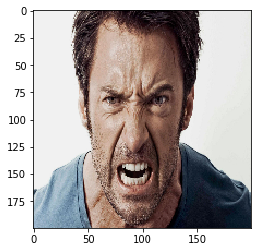

In [28]:
from skimage import io
img = image.load_img('../input/testimages/wallpaper2you_443897.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/testimages/wallpaper2you_443897.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])
print(np.argmax(custom))
#emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
#print('Expression Prediction:',objects[ind])

**Live Demo of Production Level Project**

[Facial Expression Detection Web App](https://faceai.herokuapp.com/)